# **Reddit Vaccine Myths Data Analysis**

In [1]:
#Importing the dependencies

!pip install spacytextblob==0.1.7
import numpy as np 
import pandas as pd 
import os
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.style as style
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10.4MB 4.3MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.1MB 34.8MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


We are loading the data here

In [2]:
df= pd.read_csv('reddit_vm.csv')
#Let's see the first five columns
df.head(5)

title  ...            timestamp
0  Health Canada approves AstraZeneca COVID-19 va...  ...  2021-02-27 06:33:45
1  COVID-19 in Canada: 'Vaccination passports' a ...  ...  2021-02-26 07:11:07
2  Coronavirus variants could fuel Canada's third...  ...  2021-02-21 07:50:08
3  Canadian government to extend COVID-19 emergen...  ...  2021-02-20 06:35:13
4  Canada: Pfizer is 'extremely committed' to mee...  ...  2021-02-16 11:36:28

[5 rows x 8 columns]

**Data Analysis**

In [3]:
#Getting a general information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1530 non-null   object 
 1   score      1530 non-null   int64  
 2   id         1530 non-null   object 
 3   url        452 non-null    object 
 4   comms_num  1530 non-null   int64  
 5   created    1530 non-null   float64
 6   body       1164 non-null   object 
 7   timestamp  1530 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 95.8+ KB


In [8]:
#Looking at the shape of the data
df.shape

(1530, 8)

We have 1530 rows and 8 columns.

### 3.3 Finding All The Categorical And Covariate Columns

In [11]:
categorical_col, non_categorical_val=[],[]

for i in df.columns:
    
    if df[i].dtype == 'object':
        categorical_col.append(i)
    else:
        non_categorical_val.append(i)
        
print('The categorical features are :')
print()
for i in range(len(categorical_col)):
    print(f'{i+1}. {categorical_col[i]}')
        
print()
print('The non-categorical features are :')
print()
for i in range(len(non_categorical_val)):
    print(f'{i+1}. {non_categorical_val[i]}')
        
print()


The categorical features are :

1. title
2. id
3. url
4. body
5. timestamp

The non-categorical features are :

1. score
2. comms_num
3. created



In [13]:
#Checking whether there is duplicate rows
df[df.duplicated()]


Empty DataFrame
Columns: [title, score, id, url, comms_num, created, body, timestamp]
Index: []

There is no duplicate rows

**Exploratory Data Analysis**

In [14]:
df.describe().T

count          mean  ...           75%           max
score      1530.0  3.721569e+00  ...  3.000000e+00  1.189000e+03
comms_num  1530.0  1.894771e+00  ...  1.000000e+00  5.960000e+02
created    1530.0  1.543342e+09  ...  1.581114e+09  1.621050e+09

[3 rows x 8 columns]

In [15]:
#Checking whether there are any null values

null_val=df.isnull().sum()/len(df)
for i in range(len(null_val.index)):
    print("Column",null_val.index[i],"has ",null_val[i]*100,"% null values")

Column title has  0.0 % null values
Column score has  0.0 % null values
Column id has  0.0 % null values
Column url has  70.45751633986929 % null values
Column comms_num has  0.0 % null values
Column created has  0.0 % null values
Column body has  23.92156862745098 % null values
Column timestamp has  0.0 % null values


**url** and **body** features have null values. Since **url** has a lot of null values, we will drop the column.

In [18]:
#To visualize data, we are creating 2 new columns as year and month using timestamp column
df['year']=pd.DatetimeIndex(df['timestamp']).year
df['month']=pd.DatetimeIndex(df['timestamp']).month
df.head(5)

title  score  ...  year month
0  Health Canada approves AstraZeneca COVID-19 va...      7  ...  2021     2
1  COVID-19 in Canada: 'Vaccination passports' a ...      2  ...  2021     2
2  Coronavirus variants could fuel Canada's third...      6  ...  2021     2
3  Canadian government to extend COVID-19 emergen...      1  ...  2021     2
4  Canada: Pfizer is 'extremely committed' to mee...      6  ...  2021     2

[5 rows x 10 columns]

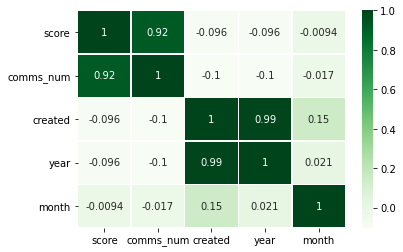

In [25]:
#Let's generate a heatmap to see the correlation between non-categorical features. 
corr = df.corr(method='pearson')
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='Greens',
            annot=True,
            linewidth=0.5);

As the heatmap shows, there is a very high correlation between the columns **comms_num** and **score**. So, one of these columns can be dropped.

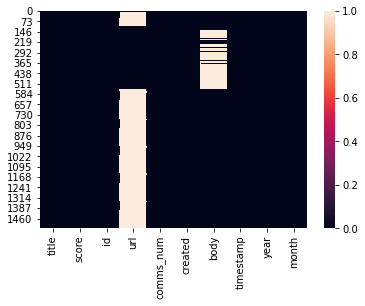

In [26]:
#Plotting the null values with heatmap
sns.heatmap(df.isnull())

The heatmap shows that highest null values are present in url, followed by body.

### 4.3 KdePlot For comms_num

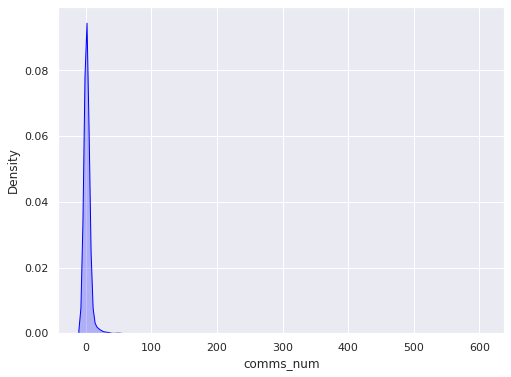

In [29]:
#We are generating a kernel density estimating plot of "comms_num" feature to visualize the distribution of observations in the dataset
sns.set(rc={'figure.figsize':(8,6)})
sns.kdeplot(df['comms_num'],color='blue',shade = True, )

### 4.4 Number Of Titles Published According to Year

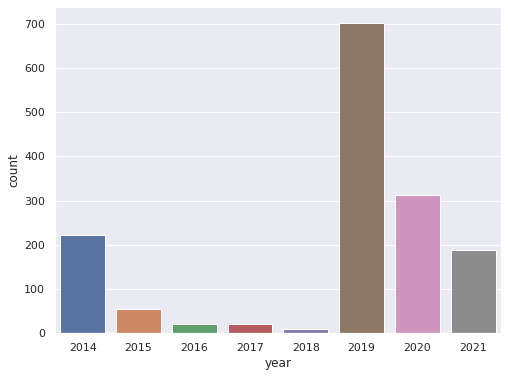

In [30]:
#We are generating a countplot to see how many titles are published each year 
sns.countplot(data=df,x='year')

Countplot shows that the highest number of articles were published in 2019, and the lowest number of articles were published in 2018.

### 4.5 Number Of Titles Published According To Month And Year

In [33]:
#Now, we will take a look at how many titles are published each month
x=pd.DataFrame()
x['Titles Published According To Month and Year']=(df.groupby(by=['year','month']).agg('count'))['title']
x=x.style.set_properties(**{'background-color': 'white'}, subset=['Titles Published According To Month and Year'])
x

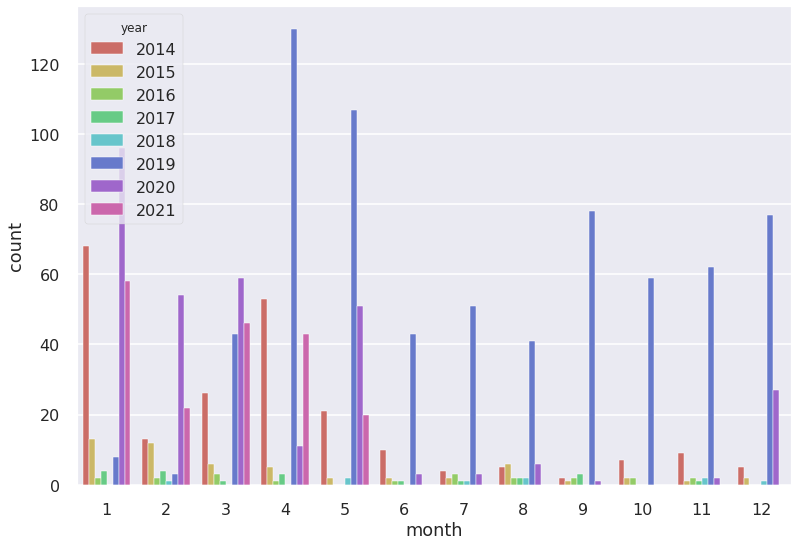

In [34]:
#Visualization of monthly publishments
style.use('seaborn-poster') 
sns.countplot(data=df, x='month',palette = 'hls',hue='year')

The highest number of articles were published in the month of January. Whereas, the lowest number of articles were published in the month of June.

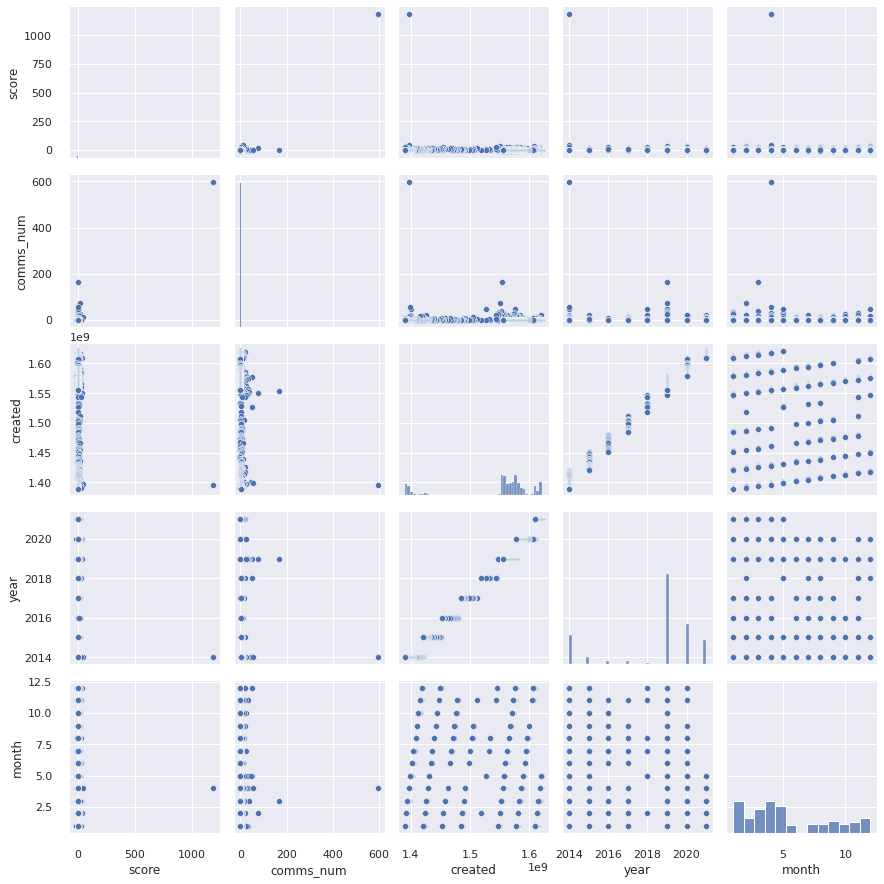

In [35]:
#Now, we are generating pairplots
sns.set(rc={'figure.figsize':(15,22)})

sns.pairplot(df)


In [36]:
#Now we can drop unnecessary columns.
df.drop(columns=['comms_num','id','url','created','timestamp'], inplace=True)
df.head()

title  score body  year  month
0  Health Canada approves AstraZeneca COVID-19 va...      7  NaN  2021      2
1  COVID-19 in Canada: 'Vaccination passports' a ...      2  NaN  2021      2
2  Coronavirus variants could fuel Canada's third...      6  NaN  2021      2
3  Canadian government to extend COVID-19 emergen...      1  NaN  2021      2
4  Canada: Pfizer is 'extremely committed' to mee...      6  NaN  2021      2

* comms_num dropped because highly correlated to score.
* id and created dropped because they are not important.
* timestamp dropped because we have already extracted year and month from it.
* url dropped because contains high number of null values.

In [37]:
#Lowercasing the text columns
df['title'] = df['title'].astype(str)
df['body'] = df['body'].astype(str)


df['title'] = df['title'].apply(lambda word: " ".join(word.lower() for word in word.split()))
df['body'] = df['body'].apply(lambda word: " ".join(word.lower() for word in word.split()))

df

title  score  ...  year  month
0     health canada approves astrazeneca covid-19 va...      7  ...  2021      2
1     covid-19 in canada: 'vaccination passports' a ...      2  ...  2021      2
2     coronavirus variants could fuel canada's third...      6  ...  2021      2
3     canadian government to extend covid-19 emergen...      1  ...  2021      2
4     canada: pfizer is 'extremely committed' to mee...      6  ...  2021      2
...                                                 ...    ...  ...   ...    ...
1525                                            comment      2  ...  2019      4
1526                                            comment      7  ...  2019      4
1527                                            comment      1  ...  2019      4
1528                                            comment      1  ...  2019      4
1529                                            comment      1  ...  2019      4

[1530 rows x 5 columns]

In [40]:
# Removing the Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


df['title'] = df['title'].apply(lambda word: " ".join(word for word in word.split() if x not in stopwords.words('english')))
df['body'] = df['body'].apply(lambda word: " ".join(word for word in word.split() if x not in stopwords.words('english')))
df.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


title  score body  year  month
0  health canada approves astrazeneca covid-19 va...      7  nan  2021      2
1  covid-19 in canada: 'vaccination passports' a ...      2  nan  2021      2
2  coronavirus variants could fuel canada's third...      6  nan  2021      2
3  canadian government to extend covid-19 emergen...      1  nan  2021      2
4  canada: pfizer is 'extremely committed' to mee...      6  nan  2021      2

Creating wordclouds for titles and bodies

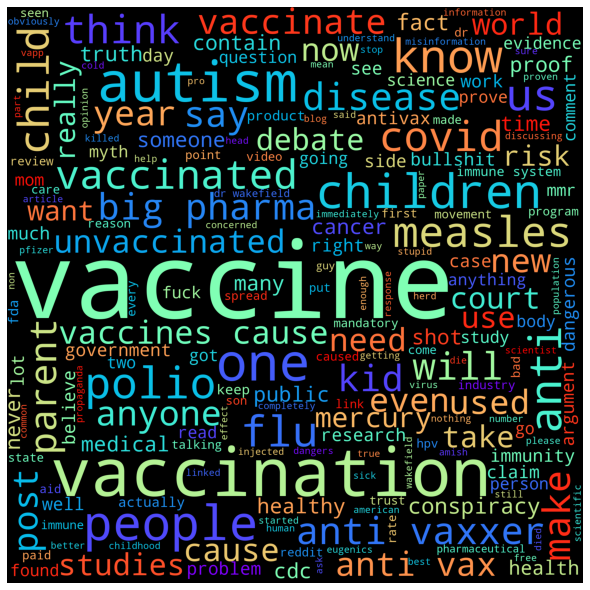

In [46]:
df_title=""
for item in df["title"]:
  df_title+=item
wordcloud=WordCloud(width = 2000, height = 2000, 
                background_color ='black', colormap = 'rainbow',
                min_font_size = 20).generate(df_title)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

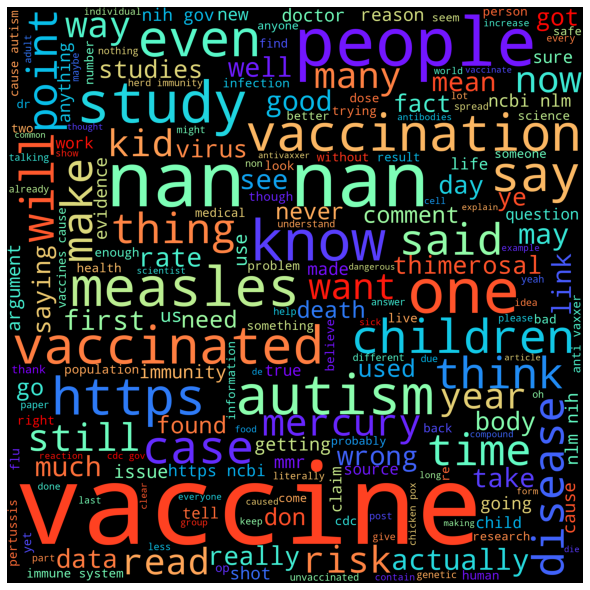

In [48]:
df_body=""
for item in df["body"]:
  df_body+=item+" "
wordcloud=WordCloud(width = 2000, height = 2000, 
                background_color ='black', colormap = 'rainbow',
                min_font_size = 20).generate(df_body)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()